## US Airlines Sentiment Analysis from Tweets: Sentiment Analysis

Dataset Source: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

#### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import Dataset, DatasetDict

import torch
from torch import nn

import transformers
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, set_seed
from transformers import DataCollatorWithPadding, AutoTokenizer
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

import evaluate

!git lfs install

NOTE: Redirects are currently not supported in Windows or MacOs.


Git LFS initialized.


#### Display Library Versions

In [2]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.9.12
         NumPy: 1.24.2
        Pandas: 1.5.0
      Datasets: 2.9.0
  Transformers: 4.26.1
         Torch: 1.12.1
      Evaluate: 0.4.0


#### Ingest & Start Preprocessing Dataset

In [3]:
parent_dir = "/Users/briandunn/Desktop/data"

data = pd.read_csv(os.path.join(parent_dir, "Tweets.csv"))

data['airline_sentiment'] = data['airline_sentiment'].str.strip()
data['text'] = data['text'].str.strip()

data.rename(columns={'airline_sentiment' : 'labels'}, inplace=True)

data.drop_duplicates(inplace=True)

data.drop(columns=['tweet_id', 'negativereason', 
                   'negativereason_confidence', 'tweet_coord', 
                   'tweet_created', 'tweet_location', 
                   'user_timezone', 'airline_sentiment_gold', 
                   'negativereason_gold', 'name', 'airline',
                   'airline_sentiment_confidence', 'retweet_count'],
          inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14604 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  14604 non-null  object
 1   text    14604 non-null  object
dtypes: object(2)
memory usage: 342.3+ KB


#### Define Dictionaries to Convert Between String & Integer Class Values

In [4]:
unique_classes = data['labels'].unique()

NUM_OF_LABELS = len(unique_classes)

id2label = {idx:label for idx, label in enumerate(unique_classes)}
label2id = {label:idx for idx, label in enumerate(unique_classes)}

#### Visual: Histogram of Text Lengths

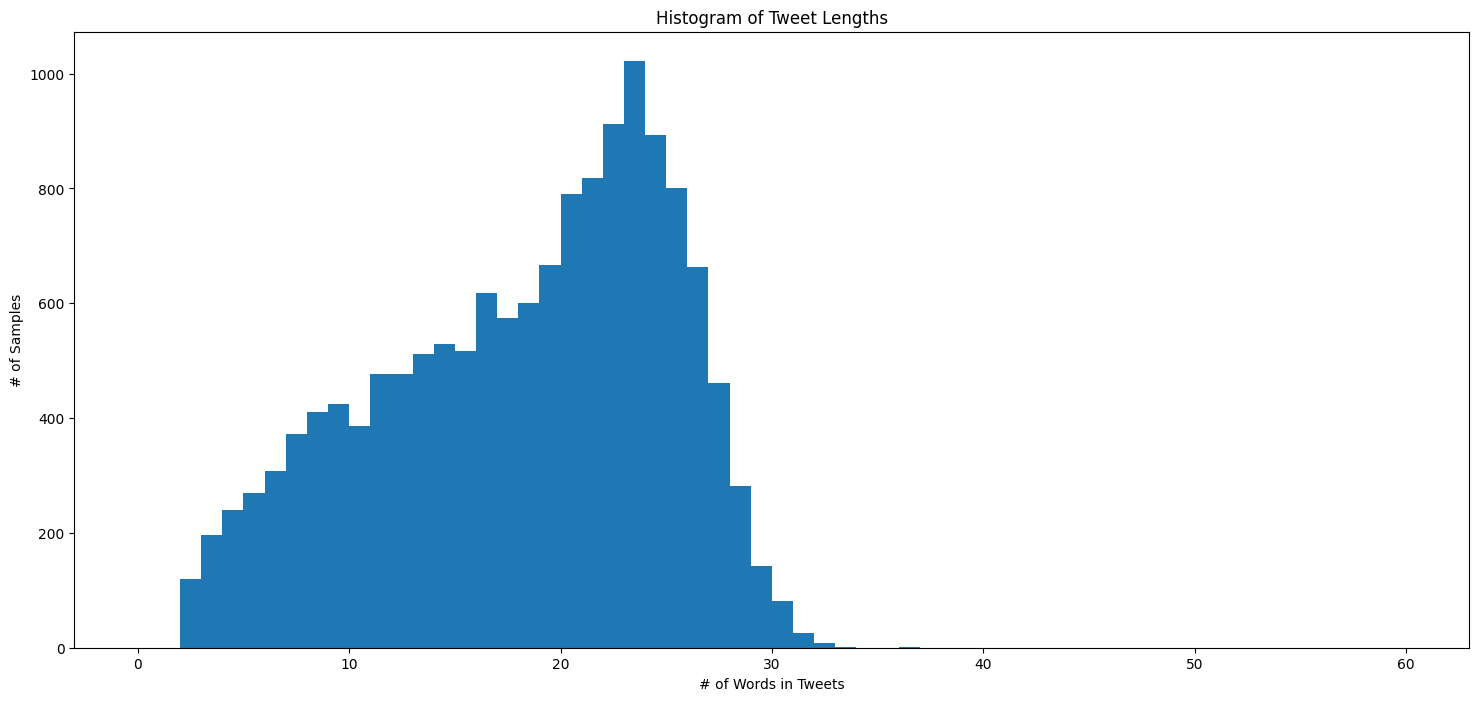

The maximum length of Speeches is 36 words.


In [5]:
data['text_length'] = data['text'].str.split().str.len()

n_bin=60
data.hist('text_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram of Tweet Lengths')
plt.xlabel('# of Words in Tweets')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of Speeches is {max(data['text_length'])} words.")

#### Visual: Tweet Length by Class

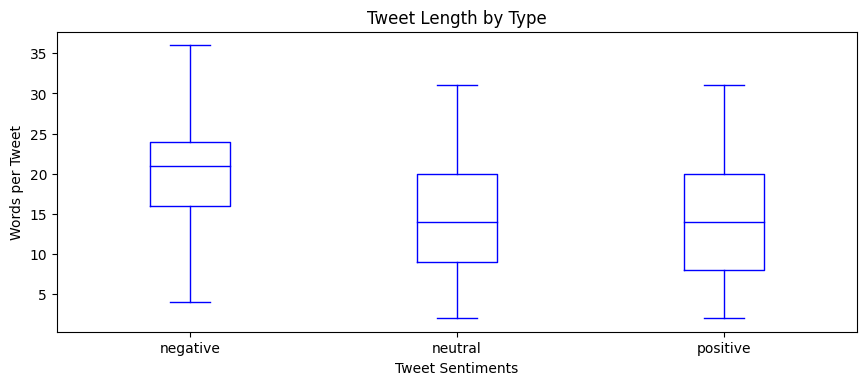

In [6]:
data.boxplot("text_length", by="labels", grid=False, showfliers=False, color="Blue", figsize=(10,4))

plt.suptitle('')
plt.title('Tweet Length by Type')
plt.xlabel('Tweet Sentiments')
plt.ylabel('Words per Tweet')
plt.show()

#### Find Largest Tokenized Input Value

In [7]:
MODEL_CKPT = "vinai/bertweet-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, 
                                             truncation=True, 
                                             padding=True,
                                             batched=True, 
                                             batch_size=None)

text_len = [len(tokenizer.encode(a)) for a in data["text"]]

MAX_LENGTH = max(text_len)

print(f"The longest tweet is {MAX_LENGTH} tokens.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The longest tweet is 67 tokens.


#### Number of Samples in Each Class

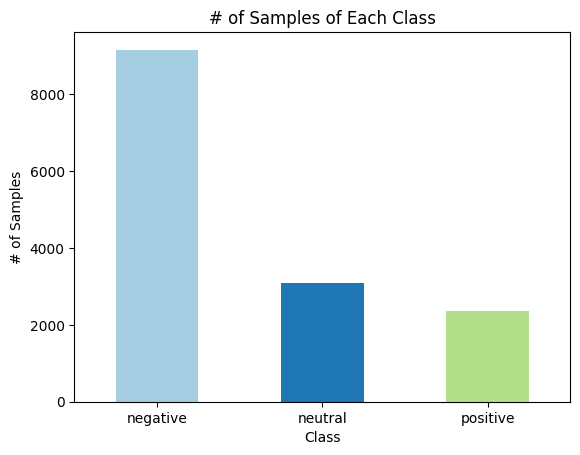

In [8]:
class_counts = data.groupby("labels").count()

class_counts['text_length'].plot.bar(label='labels', 
                                     color=plt.cm.Paired(np.arange(len(data))))
plt.suptitle('')
plt.title('# of Samples of Each Class')
plt.xlabel('Class')
plt.ylabel('# of Samples')
plt.xticks(rotation = 0)
plt.show()

#### Final Data Preprocessing

In [9]:
data = data.drop(columns=["text_length"])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14604 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  14604 non-null  object
 1   text    14604 non-null  object
dtypes: object(2)
memory usage: 342.3+ KB


#### Convert Class Values From String to Integer & Convert DataFrame to Dataset

In [10]:
data = data.replace(label2id)

dataset = Dataset.from_pandas(data)

#### Split Dataset into Training, Testing & Evaluation Datasets

In [11]:
train_testEval = dataset.train_test_split(train_size=0.65)
test_eval = train_testEval['test'].train_test_split(train_size=0.50)

ds = DatasetDict({
    'train' : train_testEval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

Training Dataset Shape: (9492, 3)
Testing Dataset Shape: (2556, 3)
Evaluation Dataset Shape: (2556, 3)


#### Basic Values/Constants

In [12]:
set_seed = 42
NUM_OF_EPOCHS = 12

BATCH_SIZE = 64
LEARNING_RATE = 2e-5

MAX_LENGTH = MAX_LENGTH + 1
MODEL_CKPT = "vinai/bertweet-base"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Twitter_Sentiment_Analysis_v3"

METRIC_NAME = "f1"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"This project will utilize the {str(DEVICE).upper()} to train and evaluate.")
print(f"This project will have a maximum length for the input text of {MAX_LENGTH} tokens.")
print(f"The model checkpoint used for this project is: {MODEL_CKPT}")

This project will utilize the CPU to train and evaluate.
This project will have a maximum length for the input text of 68 tokens.
The model checkpoint used for this project is: vinai/bertweet-base


#### Tokenize Entire Dataset

In [13]:
# Define tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, 
                                          truncation=True, 
                                          padding=True)

# Method to tokenize entire dataset
def tokenize(batch):
    return tokenizer(batch['text'], 
                     padding=True, 
                     truncation=True, 
                     max_length=MAX_LENGTH,
                     return_tensors="pt")

# Map 'tokenizer' method to entire dataset
encoded_data = ds.map(tokenize, 
                      batched=True, 
                      batch_size=None)

print('Training data shape:', encoded_data['train'].shape)
print('Testing data shape:', encoded_data['test'].shape)
print('Validation data shape:', encoded_data['eval'].shape)

print(f"Training Dataset Information: {encoded_data['train']}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Training data shape: (9492, 6)
Testing data shape: (2556, 6)
Validation data shape: (2556, 6)
Training Dataset Information: Dataset({
    features: ['labels', 'text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 9492
})


#### Instantiate Model

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT,
        num_labels=NUM_OF_LABELS,
        id2label=id2label,
        label2id=label2id
        )

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

#### Define Function to Compute Metrics

In [15]:
def compute_metrics(p):
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["f1"]
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')['f1']
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["recall"]
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["recall"]
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["precision"]
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["precision"]
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Define TrainingArguments

In [16]:
training_args = Seq2SeqTrainingArguments(
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE, 
    per_device_eval_batch_size=BATCH_SIZE, 
    weight_decay=0.01,
    log_level="error",
    logging_strategy='epoch', 
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_first_step=True,
    load_best_model_at_end=True,
    hub_private_repo=True,
    disable_tqdm=False,
    push_to_hub=True
)

#### Define Data Collator

In [17]:
data_collator = DataCollatorWithPadding(tokenizer)

#### Subclass Trainer to Handle Class Imbalance

In [18]:
class CustomTrainer(Seq2SeqTrainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#### Instantiate Trainer

In [19]:
trainer = CustomTrainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_data['train'], 
                  eval_dataset=encoded_data['eval'], 
                  data_collator=data_collator,
                  tokenizer=tokenizer)

Cloning https://huggingface.co/DunnBC22/bertweet-base-Twitter_Sentiment_Analysis_v3 into local empty directory.


#### Train Model

In [20]:
train_results = trainer.train()

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


A Jupyter Widget

{'loss': 1.1801, 'learning_rate': 1.998881431767338e-05, 'epoch': 0.01}
{'loss': 0.4404, 'learning_rate': 1.8333333333333333e-05, 'epoch': 1.0}


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

{'eval_loss': 0.28145933151245117, 'eval_accuracy': 0.831377151799687, 'eval_Weighted F1': 0.8152662569665534, 'eval_Micro F1': 0.831377151799687, 'eval_Macro F1': 0.7659612402720781, 'eval_Weighted Recall': 0.831377151799687, 'eval_Micro Recall': 0.831377151799687, 'eval_Macro Recall': 0.7560023084039112, 'eval_Weighted Precision': 0.8330844436132111, 'eval_Micro Precision': 0.831377151799687, 'eval_Macro Precision': 0.8243929447301191, 'eval_runtime': 650.5345, 'eval_samples_per_second': 3.929, 'eval_steps_per_second': 0.061, 'epoch': 1.0}
{'loss': 0.2493, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


A Jupyter Widget

{'eval_loss': 0.25583919882774353, 'eval_accuracy': 0.8587636932707355, 'eval_Weighted F1': 0.8523230017741068, 'eval_Micro F1': 0.8587636932707355, 'eval_Macro F1': 0.8150610337021057, 'eval_Weighted Recall': 0.8587636932707355, 'eval_Micro Recall': 0.8587636932707355, 'eval_Macro Recall': 0.7961304090733936, 'eval_Weighted Precision': 0.8553919408882632, 'eval_Micro Precision': 0.8587636932707355, 'eval_Macro Precision': 0.846298931599896, 'eval_runtime': 599.8884, 'eval_samples_per_second': 4.261, 'eval_steps_per_second': 0.067, 'epoch': 2.0}
{'loss': 0.1905, 'learning_rate': 1.5000000000000002e-05, 'epoch': 3.0}


A Jupyter Widget

{'eval_loss': 0.273415207862854, 'eval_accuracy': 0.857981220657277, 'eval_Weighted F1': 0.8534456404260701, 'eval_Micro F1': 0.857981220657277, 'eval_Macro F1': 0.8163608587221516, 'eval_Weighted Recall': 0.857981220657277, 'eval_Micro Recall': 0.857981220657277, 'eval_Macro Recall': 0.8093608281927497, 'eval_Weighted Precision': 0.8552903111785988, 'eval_Micro Precision': 0.857981220657277, 'eval_Macro Precision': 0.8325615773926162, 'eval_runtime': 565.6684, 'eval_samples_per_second': 4.519, 'eval_steps_per_second': 0.071, 'epoch': 3.0}
{'loss': 0.1504, 'learning_rate': 1.3333333333333333e-05, 'epoch': 4.0}


A Jupyter Widget

{'eval_loss': 0.3150421380996704, 'eval_accuracy': 0.8630672926447575, 'eval_Weighted F1': 0.8606886777980127, 'eval_Micro F1': 0.8630672926447575, 'eval_Macro F1': 0.8247382919842634, 'eval_Weighted Recall': 0.8630672926447575, 'eval_Micro Recall': 0.8630672926447575, 'eval_Macro Recall': 0.8291150982282071, 'eval_Weighted Precision': 0.862705816116082, 'eval_Micro Precision': 0.8630672926447575, 'eval_Macro Precision': 0.8278790129425619, 'eval_runtime': 578.9881, 'eval_samples_per_second': 4.415, 'eval_steps_per_second': 0.069, 'epoch': 4.0}
{'loss': 0.112, 'learning_rate': 1.1666666666666668e-05, 'epoch': 5.0}


A Jupyter Widget

{'eval_loss': 0.34512755274772644, 'eval_accuracy': 0.8564162754303599, 'eval_Weighted F1': 0.852179014840447, 'eval_Micro F1': 0.8564162754303599, 'eval_Macro F1': 0.8144563564951391, 'eval_Weighted Recall': 0.8564162754303599, 'eval_Micro Recall': 0.8564162754303599, 'eval_Macro Recall': 0.8136237462474657, 'eval_Weighted Precision': 0.8543956988926455, 'eval_Micro Precision': 0.8564162754303599, 'eval_Macro Precision': 0.825393357422417, 'eval_runtime': 567.3801, 'eval_samples_per_second': 4.505, 'eval_steps_per_second': 0.07, 'epoch': 5.0}
{'loss': 0.0885, 'learning_rate': 1e-05, 'epoch': 6.0}


A Jupyter Widget

{'eval_loss': 0.3929468095302582, 'eval_accuracy': 0.8575899843505478, 'eval_Weighted F1': 0.853202195770963, 'eval_Micro F1': 0.8575899843505478, 'eval_Macro F1': 0.8157919515356019, 'eval_Weighted Recall': 0.8575899843505478, 'eval_Micro Recall': 0.8575899843505478, 'eval_Macro Recall': 0.8122916477316983, 'eval_Weighted Precision': 0.8554462830282233, 'eval_Micro Precision': 0.8575899843505478, 'eval_Macro Precision': 0.8293369143566941, 'eval_runtime': 573.1367, 'eval_samples_per_second': 4.46, 'eval_steps_per_second': 0.07, 'epoch': 6.0}
{'loss': 0.0735, 'learning_rate': 8.333333333333334e-06, 'epoch': 7.0}


A Jupyter Widget

{'eval_loss': 0.42331376671791077, 'eval_accuracy': 0.8564162754303599, 'eval_Weighted F1': 0.8541169270367671, 'eval_Micro F1': 0.8564162754303599, 'eval_Macro F1': 0.8164180127004128, 'eval_Weighted Recall': 0.8564162754303599, 'eval_Micro Recall': 0.8564162754303599, 'eval_Macro Recall': 0.812784398823461, 'eval_Weighted Precision': 0.8535006341251252, 'eval_Micro Precision': 0.8564162754303599, 'eval_Macro Precision': 0.822478711663491, 'eval_runtime': 571.9589, 'eval_samples_per_second': 4.469, 'eval_steps_per_second': 0.07, 'epoch': 7.0}
{'loss': 0.0642, 'learning_rate': 6.666666666666667e-06, 'epoch': 8.0}


A Jupyter Widget

{'eval_loss': 0.4453563392162323, 'eval_accuracy': 0.8525039123630673, 'eval_Weighted F1': 0.8495444621254444, 'eval_Micro F1': 0.8525039123630673, 'eval_Macro F1': 0.8105684183557312, 'eval_Weighted Recall': 0.8525039123630673, 'eval_Micro Recall': 0.8525039123630673, 'eval_Macro Recall': 0.8055219764142899, 'eval_Weighted Precision': 0.8491269844761435, 'eval_Micro Precision': 0.8525039123630673, 'eval_Macro Precision': 0.8192180921812265, 'eval_runtime': 572.0785, 'eval_samples_per_second': 4.468, 'eval_steps_per_second': 0.07, 'epoch': 8.0}
{'loss': 0.0512, 'learning_rate': 5e-06, 'epoch': 9.0}


A Jupyter Widget

{'eval_loss': 0.5097847580909729, 'eval_accuracy': 0.8536776212832551, 'eval_Weighted F1': 0.8542759763876561, 'eval_Micro F1': 0.8536776212832552, 'eval_Macro F1': 0.8194131708413148, 'eval_Weighted Recall': 0.8536776212832551, 'eval_Micro Recall': 0.8536776212832551, 'eval_Macro Recall': 0.8260553760444461, 'eval_Weighted Precision': 0.855221336384112, 'eval_Micro Precision': 0.8536776212832551, 'eval_Macro Precision': 0.8133108904026297, 'eval_runtime': 570.9909, 'eval_samples_per_second': 4.476, 'eval_steps_per_second': 0.07, 'epoch': 9.0}
{'loss': 0.0448, 'learning_rate': 3.3333333333333333e-06, 'epoch': 10.0}


A Jupyter Widget

{'eval_loss': 0.526820719242096, 'eval_accuracy': 0.8536776212832551, 'eval_Weighted F1': 0.8538481512055572, 'eval_Micro F1': 0.8536776212832552, 'eval_Macro F1': 0.8170176858285143, 'eval_Weighted Recall': 0.8536776212832551, 'eval_Micro Recall': 0.8536776212832551, 'eval_Macro Recall': 0.8256068614028385, 'eval_Weighted Precision': 0.8549247444089283, 'eval_Micro Precision': 0.8536776212832551, 'eval_Macro Precision': 0.8100980212127529, 'eval_runtime': 571.9499, 'eval_samples_per_second': 4.469, 'eval_steps_per_second': 0.07, 'epoch': 10.0}
{'loss': 0.038, 'learning_rate': 1.6666666666666667e-06, 'epoch': 11.0}


A Jupyter Widget

{'eval_loss': 0.5075616836547852, 'eval_accuracy': 0.8564162754303599, 'eval_Weighted F1': 0.8554827671738346, 'eval_Micro F1': 0.8564162754303599, 'eval_Macro F1': 0.819496211690825, 'eval_Weighted Recall': 0.8564162754303599, 'eval_Micro Recall': 0.8564162754303599, 'eval_Macro Recall': 0.8209341155445992, 'eval_Weighted Precision': 0.8551488487314007, 'eval_Micro Precision': 0.8564162754303599, 'eval_Macro Precision': 0.8190888119088507, 'eval_runtime': 587.093, 'eval_samples_per_second': 4.354, 'eval_steps_per_second': 0.068, 'epoch': 11.0}
{'loss': 0.0357, 'learning_rate': 0.0, 'epoch': 12.0}


A Jupyter Widget

{'eval_loss': 0.5141078233718872, 'eval_accuracy': 0.8552425665101722, 'eval_Weighted F1': 0.8540547000972106, 'eval_Micro F1': 0.8552425665101722, 'eval_Macro F1': 0.8178170962378611, 'eval_Weighted Recall': 0.8552425665101722, 'eval_Micro Recall': 0.8552425665101722, 'eval_Macro Recall': 0.8206711713857109, 'eval_Weighted Precision': 0.8540706838075035, 'eval_Micro Precision': 0.8552425665101722, 'eval_Macro Precision': 0.8170713984251171, 'eval_runtime': 568.8392, 'eval_samples_per_second': 4.493, 'eval_steps_per_second': 0.07, 'epoch': 12.0}
{'train_runtime': 89927.9673, 'train_samples_per_second': 1.267, 'train_steps_per_second': 0.02, 'train_loss': 0.12862661567577047, 'epoch': 12.0}


#### Push Model to HuggingFace Hub

In [21]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


A Jupyter Widget

A Jupyter Widget

To https://huggingface.co/DunnBC22/bertweet-base-Twitter_Sentiment_Analysis_v3
   109f7e5..4e45327  main -> main

To https://huggingface.co/DunnBC22/bertweet-base-Twitter_Sentiment_Analysis_v3
   4e45327..0186c16  main -> main



'https://huggingface.co/DunnBC22/bertweet-base-Twitter_Sentiment_Analysis_v3/commit/4e4532702ebea848905b6446f7685f5c7ff12cd9'

#### Save Model & Metrics on Training Dataset

In [22]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =              12.0
  train_loss               =            0.1286
  train_runtime            = 1 day, 0:58:47.96
  train_samples_per_second =             1.267
  train_steps_per_second   =              0.02


#### Evaluate, Log, & Save (Evaluation) Metrics

In [23]:
metrics = trainer.evaluate(encoded_data['eval'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

A Jupyter Widget

***** eval metrics *****
  epoch                   =       12.0
  eval_Macro F1           =     0.8151
  eval_Macro Precision    =     0.8463
  eval_Macro Recall       =     0.7961
  eval_Micro F1           =     0.8588
  eval_Micro Precision    =     0.8588
  eval_Micro Recall       =     0.8588
  eval_Weighted F1        =     0.8523
  eval_Weighted Precision =     0.8554
  eval_Weighted Recall    =     0.8588
  eval_accuracy           =     0.8588
  eval_loss               =     0.2558
  eval_runtime            = 0:09:34.60
  eval_samples_per_second =      4.448
  eval_steps_per_second   =       0.07


### Notes & Other Takeaways From This Project
****
- This project could be used as the basis for a twitter sentiment analysis tool.
- Seemingly, the only additional way to improve this model is to use the larger checkpoint (BERTweet-Large) instead of the BERTweet-Base checkpoint for training.

****

### Citations

- Model Checkpoint
    > @inproceedings{bertweet, title = {{BERTweet: A pre-trained language model for English Tweets}}, author = {Dat Quoc Nguyen and Thanh Vu and Anh Tuan Nguyen}, booktitle = {Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing: System Demonstrations}, pages = {9--14}, year = {2020}}
